<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/PyTorchInception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
transform = {
        'train': transforms.Compose([
            transforms.Resize([300,300]), # Resizing the image as the Inception model only takes 299 or greater
            transforms.RandomHorizontalFlip(), # Flip the data horizontally (Augmentation)
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ]),
        'test': transforms.Compose([
            transforms.Resize([300,300]),
            #transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])
    }

dataset = ImageFolder('/content/drive/MyDrive/cancer_dataG', transform=transform['train'])

In [6]:
dataset

Dataset ImageFolder
    Number of datapoints: 750
    Root location: /content/drive/MyDrive/cancer_dataG
    StandardTransform
Transform: Compose(
               Resize(size=[300, 300], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
trainset, testset = torch.utils.data.random_split(dataset, [700, 50])

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2)

In [9]:
import numpy as np

In [10]:
trainset[0][0].shape

torch.Size([3, 300, 300])

Feature batch shape: torch.Size([32, 3, 300, 300])
Labels batch shape: torch.Size([32])


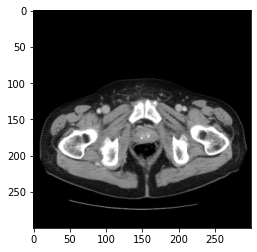

Label: 1


In [11]:
features, labels = next(iter(trainloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].squeeze()
label = labels[0]
plt.imshow(img[0,:,:], cmap="gray")
plt.show()
print(f"Label: {label}")

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

inception = models.inception_v3()
inception.fc


/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


Linear(in_features=2048, out_features=1000, bias=True)

In [13]:
# Removing FCL last layer (1000 classes to 3 classes)
inception.fc = nn.Linear(2048, 3)
inception.to('cuda') # using gpu

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.AdamW(inception.parameters(), lr=0.002)  #learning rate

In [15]:
history = {'epoch':[], 'loss':[]}
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = inception(inputs) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 5 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            running_loss = 0.0
    
    history['epoch'].append(epoch+1)
    history['loss'].append(running_loss)

print('Finished Training')


[1,     5] loss: 4.502
[1,    10] loss: 1.845
[1,    15] loss: 0.499
[1,    20] loss: 0.070
[2,     5] loss: 0.099
[2,    10] loss: 0.192
[2,    15] loss: 0.035
[2,    20] loss: 0.256
[3,     5] loss: 0.003
[3,    10] loss: 0.049
[3,    15] loss: 0.054
[3,    20] loss: 0.011
[4,     5] loss: 0.003
[4,    10] loss: 0.004
[4,    15] loss: 0.002
[4,    20] loss: 0.002
[5,     5] loss: 0.001
[5,    10] loss: 0.003
[5,    15] loss: 0.008
[5,    20] loss: 0.000
[6,     5] loss: 0.079
[6,    10] loss: 0.004
[6,    15] loss: 0.002
[6,    20] loss: 0.047
[7,     5] loss: 0.015
[7,    10] loss: 0.055
[7,    15] loss: 0.466
[7,    20] loss: 0.007
[8,     5] loss: 0.424
[8,    10] loss: 0.057
[8,    15] loss: 0.263
[8,    20] loss: 0.053
[9,     5] loss: 0.008
[9,    10] loss: 0.009
[9,    15] loss: 0.002
[9,    20] loss: 0.007
[10,     5] loss: 0.001
[10,    10] loss: 0.002
[10,    15] loss: 0.001
[10,    20] loss: 0.000
Finished Training


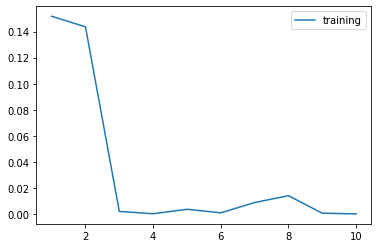

In [16]:
plt.plot(history['epoch'], history['loss'], label='training')
plt.legend()
plt.show()

Feature batch shape: torch.Size([32, 3, 300, 300])
Labels batch shape: torch.Size([32])


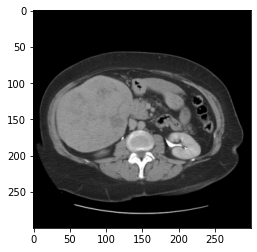

Label: 2


In [17]:
features, labels = next(iter(testloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].squeeze()
label = labels[0]
plt.imshow(img[0,:,:], cmap="gray")
plt.show()
print(f"Label: {label}")

In [18]:
outputs, _ = inception(features.to('cuda'))

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{predicted[j]}'
                              for j in range(4)))

Predicted:  2 0 0 2


In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs, _ = inception(images.to('cuda'))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.cpu().data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 50 test images: {100 * correct // total} %')

Accuracy of the network on the 50 test images: 100 %


In [21]:
classes = (0, 1, 2)
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs, _ = inception(images.to('cuda'))
        _, predictions = torch.max(outputs.cpu(), 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: 0 is 100.0 %
Accuracy for class: 1 is 100.0 %
Accuracy for class: 2 is 100.0 %
